<a href="https://colab.research.google.com/github/KarolChlasta/PJAIT-AdvancedML/blob/master/ZTM05_DeepEyes-Scanpaths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple DeepEyes II

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [0]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
#alexnet = models.alexnet(pretrained=True)
#squeezenet = models.squeezenet1_0(pretrained=True)
#vgg16 = models.vgg16(pretrained=True)
#densenet = models.densenet161(pretrained=True)
#inception = models.inception_v3(pretrained=True)
#googlenet = models.googlenet(pretrained=True)
#shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
#mobilenet = models.mobilenet_v2(pretrained=True)
#resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
#wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
#mnasnet = models.mnasnet1_0(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.5MB/s]


In [0]:
bs = 2

architecture = models.resnet18 # ResNet 18

## Looking at the data

We are going to use the SWPS Dataset which features 3 mental states in 60 people. Our model will need to learn to differentiate between 3 distinct cathegories (anxious/depressive/control).

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir data
!cp /content/drive/My\ Drive/DeepEyes/images-scanpaths-clean-448x448.tar.gz /content/data/
!tar -xvf /content/data/images-scanpaths-clean-448x448.tar.gz -C data


#!mkdir data
#!cp /content/drive/My\ Drive/DeepEyes/images-fixations-augmented.tar.gz /content/data/
#!tar -xvf /content/data/images-fixations-augmented.tar.gz -C data

images-scanpaths-clean-448x448/
images-scanpaths-clean-448x448/anxious_K705.png
images-scanpaths-clean-448x448/anxious_92168.png
images-scanpaths-clean-448x448/anxious_K903.png
images-scanpaths-clean-448x448/depressive_MD240.png
images-scanpaths-clean-448x448/depressive_WD231.png
images-scanpaths-clean-448x448/anxious_92179.png
images-scanpaths-clean-448x448/control_92270.png
images-scanpaths-clean-448x448/anxious_K912.png
images-scanpaths-clean-448x448/depressive_WD220.png
images-scanpaths-clean-448x448/control_K906.png
images-scanpaths-clean-448x448/anxious_91130.png
images-scanpaths-clean-448x448/control_91117.png
images-scanpaths-clean-448x448/control_91133.png
images-scanpaths-clean-448x448/depressive_WD234.png
images-scanpaths-clean-448x448/anxious_91234.png
images-scanpaths-clean-448x448/depressive_WD229.png
images-scanpaths-clean-448x448/depressive_MD233.png
images-scanpaths-clean-448x448/control_WD203.png
images-scanpaths-clean-448x448/anxious_92103.png
images-scanpaths-clean-

In [0]:
path_img = '/content/data/images-scanpaths-clean-448x448/'
#path_img = '/content/data/images-fixations-augmented/'

In [0]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

## Data augmentation

In [0]:
src = ImageList.from_folder(path_img).split_by_rand_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'/([^/]+)_\w+.png$')       
           .databunch(bs=bs, num_workers=0).normalize(imagenet_stats))

In [0]:
data = get_data(448, bs, 'zeros')

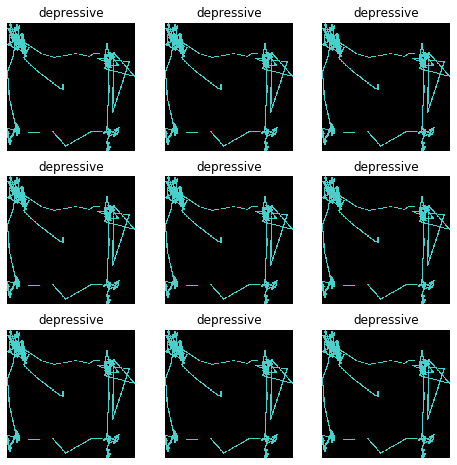

In [0]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
data = get_data(448,bs)

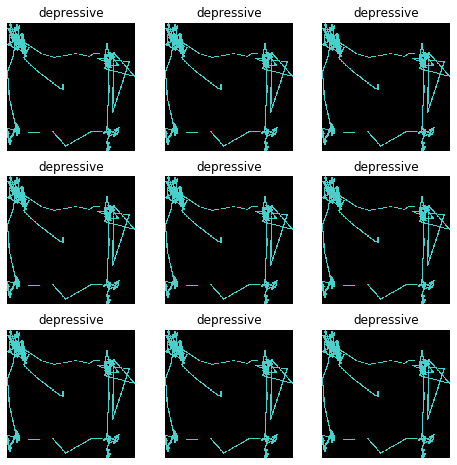

In [0]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [0]:
gc.collect()
learn = cnn_learner(data, architecture, metrics=error_rate, bn_final=True, pretrained=True)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-06
Min loss divided by 10: 3.02E-04


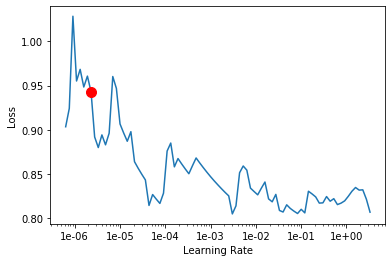

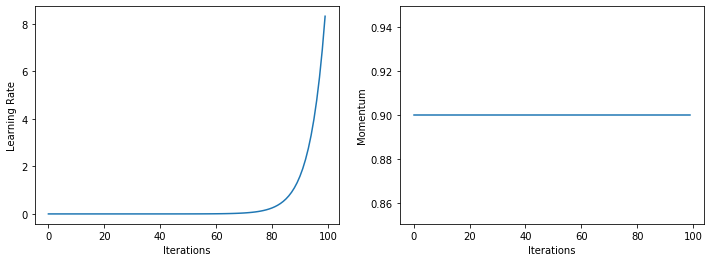

In [0]:
learn.recorder.plot(suggestion=True)
learn.recorder.plot_lr(show_moms=True)

In [0]:
learn.fit_one_cycle(4, 1e-01, pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.759272,0.682002,0.250000,00:00
1,0.733299,0.467365,0.250000,00:00
2,0.721792,0.779063,0.375000,00:00
3,0.712187,0.724920,0.250000,00:00


Min numerical gradient: 2.08E-02
Min loss divided by 10: 9.56E-03


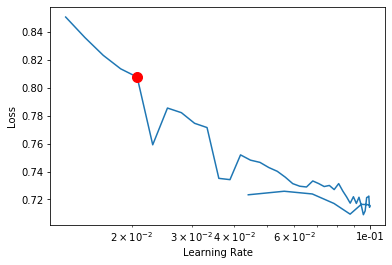

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, learn.recorder.min_grad_lr, pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.642527,2.605033,0.625000,00:00
1,0.668996,0.687475,0.500000,00:00
2,0.664025,63.917885,0.375000,00:00
3,0.651317,1.802481,0.375000,00:00
4,0.679942,0.637200,0.250000,00:00


In [0]:
data = get_data(352,bs)
learn.data = data

In [0]:
learn.save('352')

## Results

In [0]:
def evaluate_model_from_interp(interp, data):
    print(f'Interp has {len(interp.y_true)} ground truth labels: {interp.y_true}')
    print(f'Interp yielded {len(interp.preds)} raw predictions. First two raw predictions are: {interp.preds[:2]}')
    print(f'The problem had {len(data.classes)} classes: {data.classes}') # data.c is just len(data.classes)
    
    print('')
    print(f'Pred -> GroundTruth = PredLabel -> GroundTruthLabel')
    
    ok_pred = 0
    
    for idx, raw_p in enumerate(interp.preds):
        pred = np.argmax(raw_p)
        if idx < 10:
           print(f'{pred} -> {interp.y_true[idx]} = {data.classes[pred]} -> {data.valid_ds.y[idx]}')
        if pred == interp.y_true[idx]:
           ok_pred += 1
    
    acc = ok_pred / len(interp.y_true)
    print(f'Overall accuracy of the model: {acc:0.5f}')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

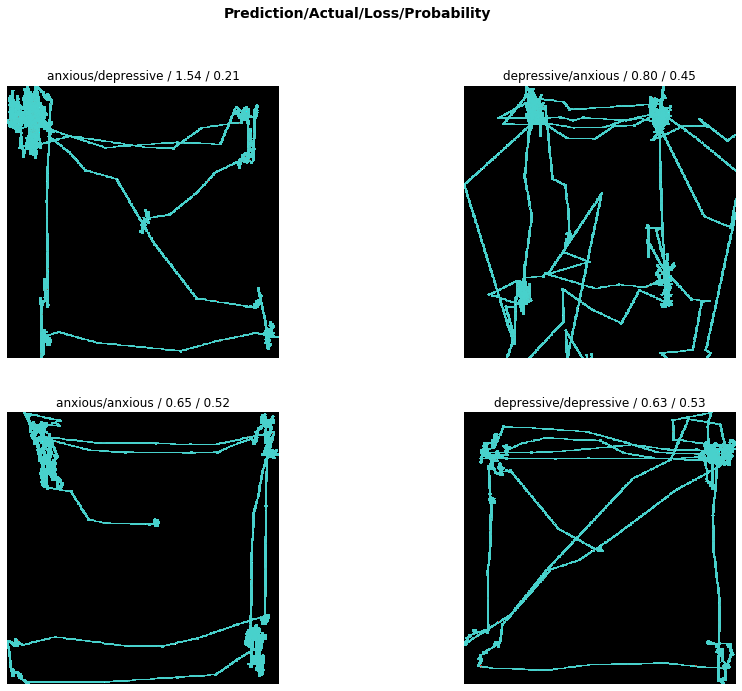

In [0]:
interp.plot_top_losses(4, figsize=(15,11))

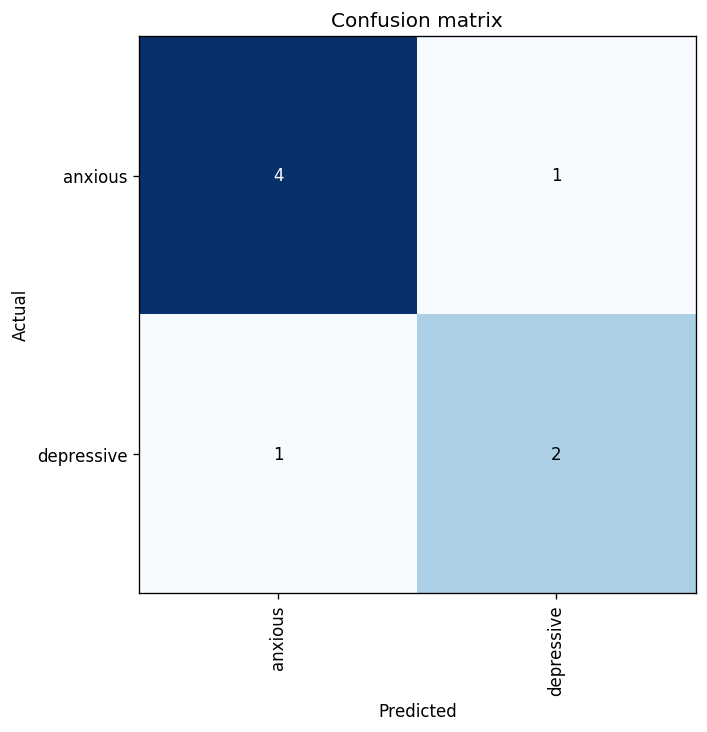

In [0]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=120)

In [0]:
interp.most_confused(min_val=2)

[]

In [0]:
evaluate_model_from_interp(interp, data)

Interp has 8 ground truth labels: tensor([1, 0, 0, 0, 0, 0, 1, 1])
Interp yielded 8 raw predictions. First two raw predictions are: tensor([[0.7855, 0.2145],
        [0.4487, 0.5513]])
The problem had 2 classes: ['anxious', 'depressive']

Pred -> GroundTruth = PredLabel -> GroundTruthLabel
0 -> 1 = anxious -> depressive
1 -> 0 = depressive -> anxious
0 -> 0 = anxious -> anxious
0 -> 0 = anxious -> anxious
0 -> 0 = anxious -> anxious
0 -> 0 = anxious -> anxious
1 -> 1 = depressive -> depressive
1 -> 1 = depressive -> depressive
Overall accuracy of the model: 0.75000


## End